In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
pip install datasets

In [8]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

from transformers import AutoTokenizer
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

## Data preparation
[SemEval-2014 Task 4: Aspect Based Sentiment Analysis](https://aclanthology.org/S14-2004/) (Pontiki et al., SemEval 2014)

In [9]:
#Dataset from https://huggingface.co/datasets/tomaarsen/setfit-absa-semeval-restaurants
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/tomaarsen/setfit-absa-semeval-restaurants/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
df.rename(columns={"span": "aspect"}, inplace=True)
df = df[['text', 'aspect', 'label']]
df = df[df["label"] != "conflict"]
df = df.dropna()

## Basic information of the dataset
Such as text lengths, unique values, common aspects and value counts.

In [ ]:
df

,text,aspect,label
0,But the staff was so horrible to us.,staff,negative
1,"To be completely fair, the only redeeming fact...",food,positive
2,"The food is uniformly exceptional, with a very...",food,positive
3,"The food is uniformly exceptional, with a very...",kitchen,positive
4,"The food is uniformly exceptional, with a very...",menu,neutral
...,...,...,...
3688,Each table has a pot of boiling water sunken i...,pot of boiling water,neutral
3689,Each table has a pot of boiling water sunken i...,meats,neutral
3690,Each table has a pot of boiling water sunken i...,vegetables,neutral
3691,Each table has a pot of boiling water sunken i...,rice,neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3602 entries, 0 to 3692
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3602 non-null   object
 1   aspect  3602 non-null   object
 2   label   3602 non-null   object
dtypes: object(3)
memory usage: 112.6+ KB


In [ ]:
df.nunique()

,0
text,1976
aspect,1268
label,3


In [ ]:
df['label'].value_counts()

,count
label,
positive,2164
negative,805
neutral,633


In [ ]:
print(f"Minimum length: {df['text'].apply(len).min()} char")
print(f"Average length: {df['text'].apply(len).mean():.1f} char")
print(f"Maximum length: {df['text'].apply(len).max()} char")
print(f"Minimum length: {df['text'].apply(lambda s: len(s.split())).min()} words")
print(f"Average length: {df['text'].apply(lambda s: len(s.split())).mean():.1f} words")
print(f"Maximum length: {df['text'].apply(lambda s: len(s.split())).max()} words")

Minimum length: 10 char
Average length: 96.5 char
Maximum length: 357 char
Minimum length: 1 words
Average length: 17.5 words
Maximum length: 69 words


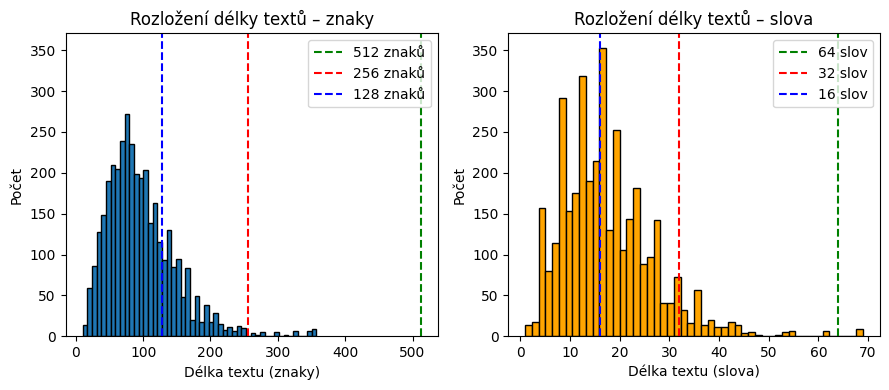

In [ ]:
# Graphs for lengths of text, in characters and in words
dff = df.copy()
dff["char_len"] = dff["text"].apply(len)
dff["word_len"] = dff["text"].apply(lambda s: len(s.split()))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].hist(dff["char_len"], bins=50, edgecolor="black")
axes[0].axvline(512,  color="g", linestyle="--", label="512 znaků")
axes[0].axvline(256,  color="r", linestyle="--", label="256 znaků")
axes[0].axvline(128,  color="b", linestyle="--", label="128 znaků")
axes[0].set_xlabel("Délka textu (znaky)")
axes[0].set_ylabel("Počet")
axes[0].set_title("Rozložení délky textů – znaky")
axes[0].legend()

axes[1].hist(dff["word_len"], bins=50, edgecolor="black", color="orange")
axes[1].axvline(64,  color="g", linestyle="--", label="64 slov")
axes[1].axvline(32,  color="r", linestyle="--", label="32 slov")
axes[1].axvline(16,  color="b", linestyle="--", label="16 slov")
axes[1].set_xlabel("Délka textu (slova)")
axes[1].set_ylabel("Počet")
axes[1].set_title("Rozložení délky textů – slova")
axes[1].legend()

max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)

axes[0].set_yticks(range(0, int(max_y), 50))
axes[1].set_yticks(range(0, int(max_y), 50))

plt.tight_layout()
plt.show()

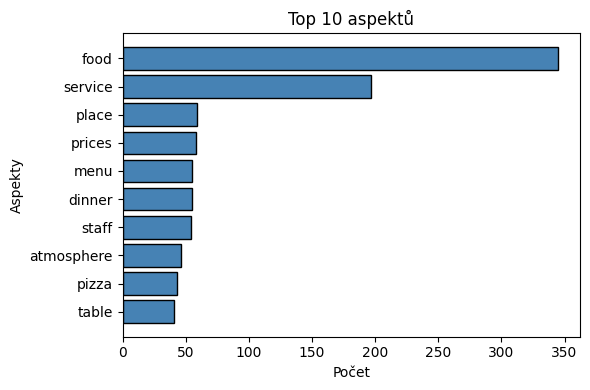

In [11]:
# Find the TOP 10 aspects
topN = 10
cat_counts = (df["aspect"].value_counts().head(topN).sort_values(ascending=True))

aspects = cat_counts.index.tolist()
frequencies = cat_counts.values.tolist()

plt.figure(figsize=(6, 4))

bar_color = "steelblue"
y_pos = range(len(aspects))

plt.barh(y_pos, frequencies, color=bar_color, edgecolor="black")
plt.yticks(y_pos, aspects)
plt.xlabel("Počet")
plt.ylabel("Aspekty")
plt.title(f"Top {topN} aspektů")
plt.tight_layout()
plt.show()

## Data seperation into train, val, test subsets

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)
train_df.to_csv("/content/drive/MyDrive/Newton/SemEval-Restaurants/data/train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/Newton/SemEval-Restaurants/data/val.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Newton/SemEval-Restaurants/data/test.csv", index=False)
print(f"Train set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

Train set size: 2521
Validation set size: 720
Test set size: 361


In [ ]:
print(f"Train set size: {train_df['label'].value_counts()}")
print(f"Validation set size: {val_df['label'].value_counts()}")
print(f"Test set size: {test_df['label'].value_counts()}")

Train set size: label
positive    1507
negative     571
neutral      443
Name: count, dtype: int64
Validation set size: label
positive    446
negative    156
neutral     118
Name: count, dtype: int64
Test set size: label
positive    211
negative     78
neutral      72
Name: count, dtype: int64


## Difference of tokens needed for each sentence in the dataset usign differen tokenizers
For large version of models wont be shown any graphs, as they are usually usign the same tokenizer, just having more parameters

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
# Function for printing graphs for the length of tokenized sentences
def plot_tokenized_text(tokenizername, data):
    tokenizer = AutoTokenizer.from_pretrained(tokenizername)

    def tokenize_function(example):
        combined_input = f"aspect: {example['aspect']} text: {example['text']}"

        encoding = tokenizer(
            combined_input,
            truncation=True,
            max_length=256
        )
        # Convert label from string to int
        encoding["label"] = label2id[example["label"]]
        return encoding

    def tokenize_functionQA(example):
        question_string = f"What is the sentiment of aspect: {example['aspect']}?"

        encoding = tokenizer(
            text=example["text"],
            text_pair=question_string,
            truncation=True,
            max_length=256
        )
        # Convert label from string to int
        encoding["label"] = label2id[example["label"]]
        return encoding

    def getLength(dataset):
        lengths = []
        for i in range(len(dataset)):
          lengths.append(len(dataset[i]))
        return lengths

    dataset = data.map(tokenize_function, batched=False, )
    datasetQA = data.map(tokenize_functionQA, batched=False)

    length = getLength(dataset['input_ids'])
    lengthQA = getLength(datasetQA['input_ids'])

    print(f"The maximum length of tokenized text in dataset with {tokenizername}: " + str(max(length)))
    print(f"The maximum length of tokenized text in dataset with {tokenizername} using QA: " + str(max(lengthQA)))

    global_max = max(max(length), max(lengthQA))
    global_min = min(min(length), min(lengthQA))
    bin_edges  = np.linspace(global_min, global_max, 50 + 1)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    counts1, _, _ = axes[0].hist(length, bins=bin_edges, edgecolor="black", color="steelblue", label='_nolegend_')
    counts2, _, _ = axes[1].hist(lengthQA, bins=bin_edges, edgecolor="black", color="forestgreen", label='_nolegend_')

    axes[0].set_title(tokenizername)
    axes[0].set_xlabel("Délka textu (tokeny)")
    axes[0].set_ylabel("Počet")

    axes[1].set_title(tokenizername + "QA")
    axes[1].set_xlabel("Délka textu (tokeny)")
    axes[1].set_ylabel("Počet")

    ymax = max(counts1.max(), counts2.max()) + 20
    axes[0].set_ylim(0, ymax)
    axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()

The maximum length of tokenized text in dataset with bert-base-uncased: 95
The maximum length of tokenized text in dataset with bert-base-uncased using QA: 100


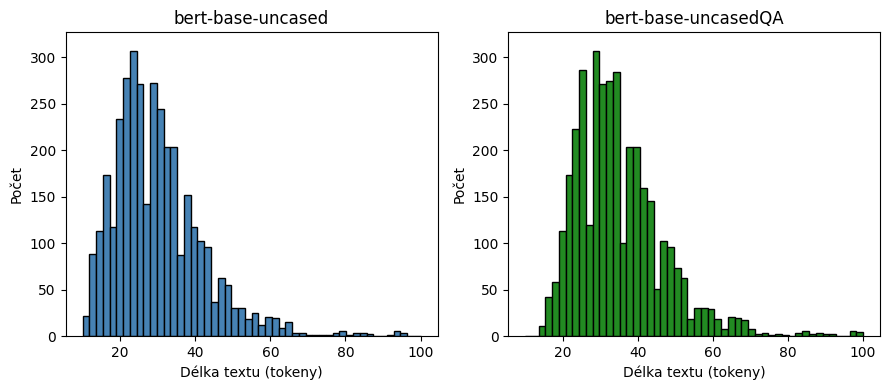

In [ ]:
plot_tokenized_text("bert-base-uncased", dataset)

The maximum length of tokenized text in dataset with bert-base-multilingual-cased: 109
The maximum length of tokenized text in dataset with bert-base-multilingual-cased using QA: 114


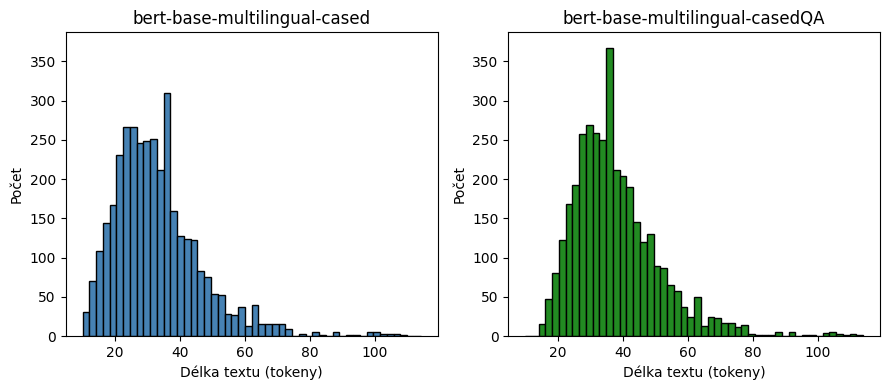

In [ ]:
plot_tokenized_text("bert-base-multilingual-cased", dataset)

The maximum length of tokenized text in dataset with roberta-base: 99
The maximum length of tokenized text in dataset with roberta-base using QA: 104


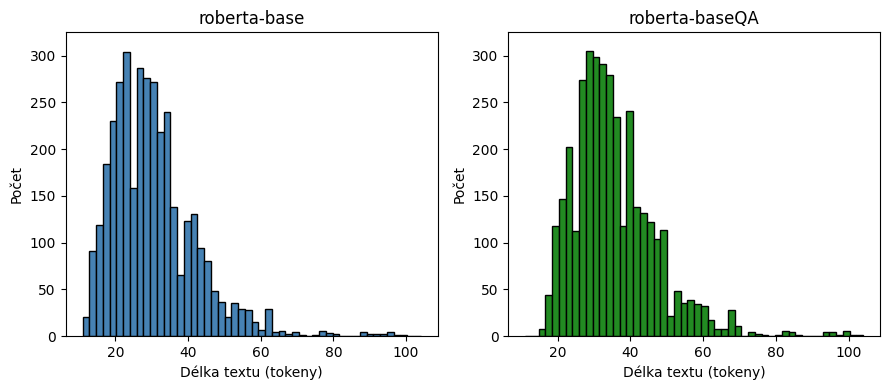

In [ ]:
plot_tokenized_text("roberta-base", dataset)

The maximum length of tokenized text in dataset with xlm-roberta-base: 101
The maximum length of tokenized text in dataset with xlm-roberta-base using QA: 107


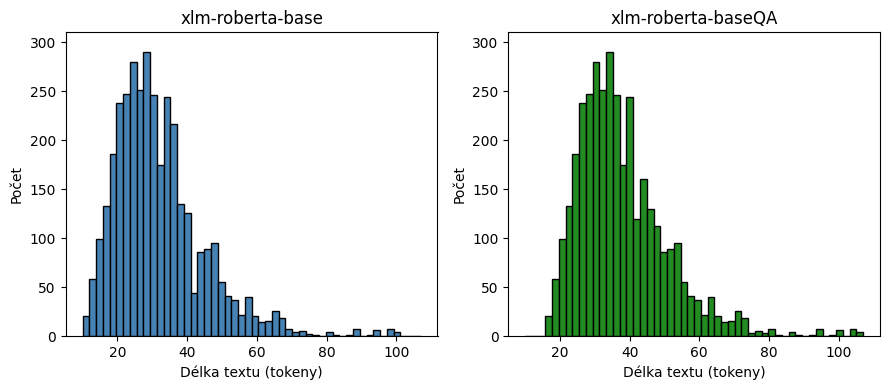

In [ ]:
plot_tokenized_text("xlm-roberta-base", dataset)

The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 90
The maximum length of tokenized text in dataset with microsoft/deberta-v3-base using QA: 95


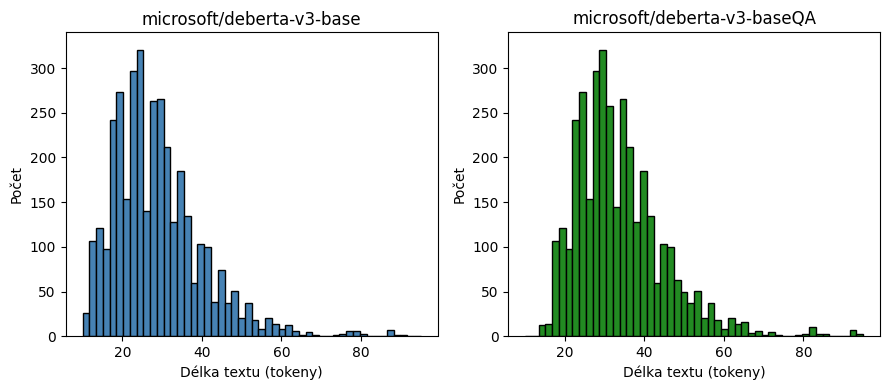

In [ ]:
plot_tokenized_text("microsoft/deberta-v3-base", dataset)

The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base: 104
The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base using QA: 108


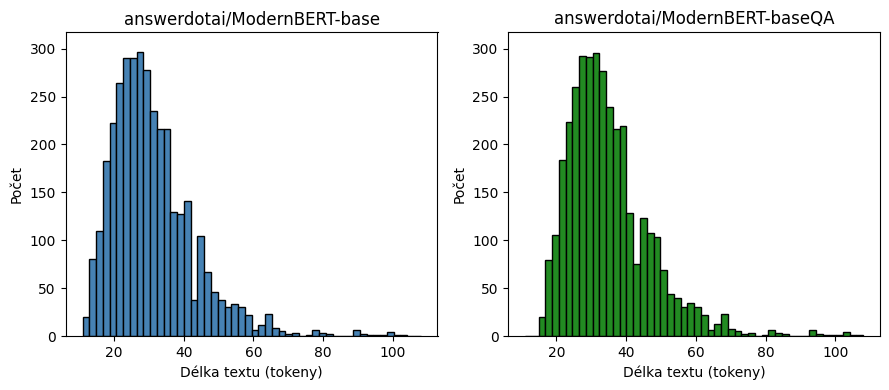

In [ ]:
plot_tokenized_text("answerdotai/ModernBERT-base", dataset)

The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased: 123
The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased using QA: 128


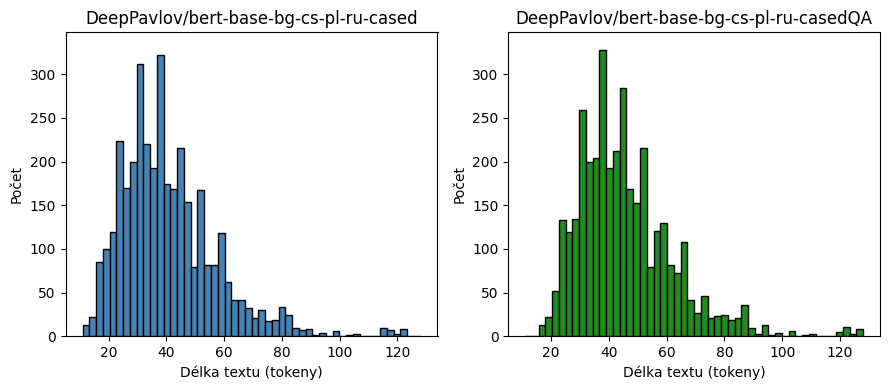

In [ ]:
plot_tokenized_text("DeepPavlov/bert-base-bg-cs-pl-ru-cased", dataset)

The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 133
The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased using QA: 140


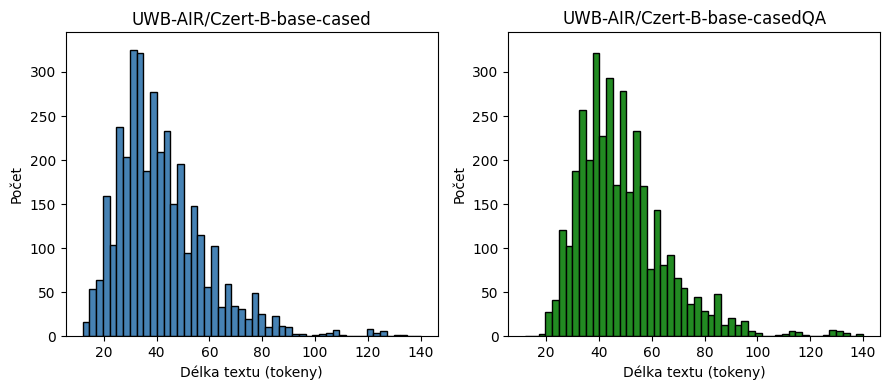

In [ ]:
plot_tokenized_text("UWB-AIR/Czert-B-base-cased", dataset)

The maximum length of tokenized text in dataset with ufal/robeczech-base: 143
The maximum length of tokenized text in dataset with ufal/robeczech-base using QA: 150


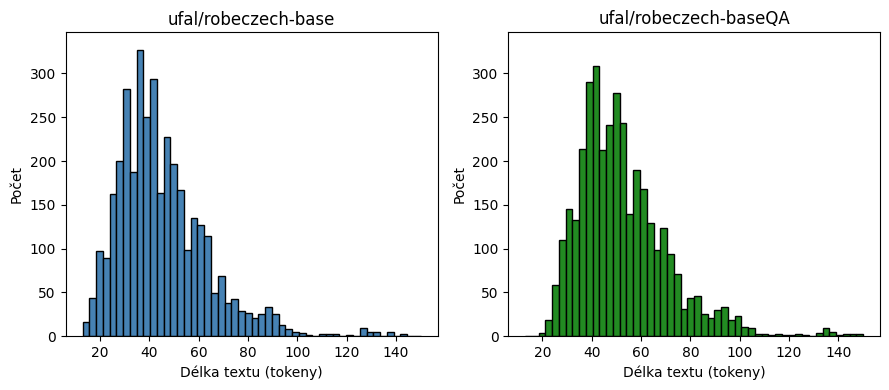

In [ ]:
plot_tokenized_text("ufal/robeczech-base", dataset)

The maximum length of tokenized text in dataset with fav-kky/FERNET-C5: 133
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5 using QA: 138


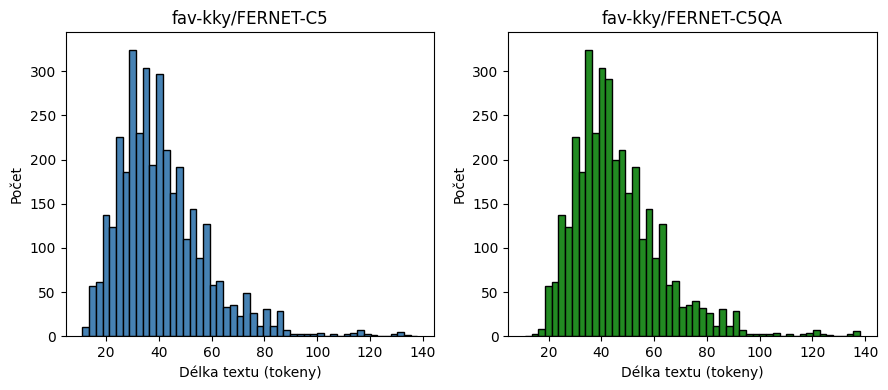

In [ ]:
plot_tokenized_text("fav-kky/FERNET-C5", dataset)

The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 149
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa using QA: 157


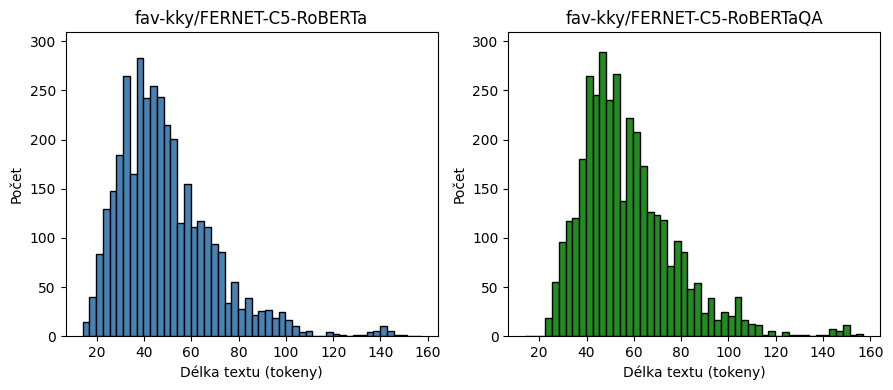

In [ ]:
plot_tokenized_text("fav-kky/FERNET-C5-RoBERTa", dataset)

In [ ]:
# Function for printing graphs for comparing the length of different tokenizors
def plot_tokenized_text_comparison(tokenizername1, tokenizername2, data):
    tokenizer1 = AutoTokenizer.from_pretrained(tokenizername1)
    tokenizer2 = AutoTokenizer.from_pretrained(tokenizername2)

    def encode(tokenizer):
        def tokenize(example):
            combined = f"aspect: {example['aspect']} text: {example['text']}"
            out = tokenizer(combined, truncation=True, max_length=512)
            out["label"] = label2id[example["label"]]
            return out
        return tokenize

    def getLength(dataset):
        lengths = []
        for i in range(len(dataset)):
          lengths.append(len(dataset[i]))
        return lengths

    dataset1 = data.map(encode(tokenizer1), batched=False, )
    dataset2 = data.map(encode(tokenizer2), batched=False)

    length1 = getLength(dataset1['input_ids'])
    length2 = getLength(dataset2['input_ids'])

    print(f"The maximum length of tokenized text in dataset with {tokenizername1}: " + str(max(length1)))
    print(f"The maximum length of tokenized text in dataset with {tokenizername2}: " + str(max(length2)))

    global_max = max(max(length1), max(length2))
    global_min = min(min(length1), min(length2))
    bin_edges  = np.linspace(global_min, global_max, 50 + 1)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    counts1, _, _ = axes[0].hist(length1, bins=bin_edges, edgecolor="black", color="steelblue", label='_nolegend_')
    counts2, _, _ = axes[1].hist(length2, bins=bin_edges, edgecolor="black", color="forestgreen", label='_nolegend_')

    axes[0].set_title(tokenizername1)
    axes[0].set_xlabel("Délka textu (tokeny)")
    axes[0].set_ylabel("Počet")

    axes[1].set_title(tokenizername2)
    axes[1].set_xlabel("Délka textu (tokeny)")
    axes[1].set_ylabel("Počet")

    ymax = max(counts1.max(), counts2.max()) + 20
    axes[0].set_ylim(0, ymax)
    axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()

Comparison between the most effective tokenizer vs the least effective tokenizer

The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 149
The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 90


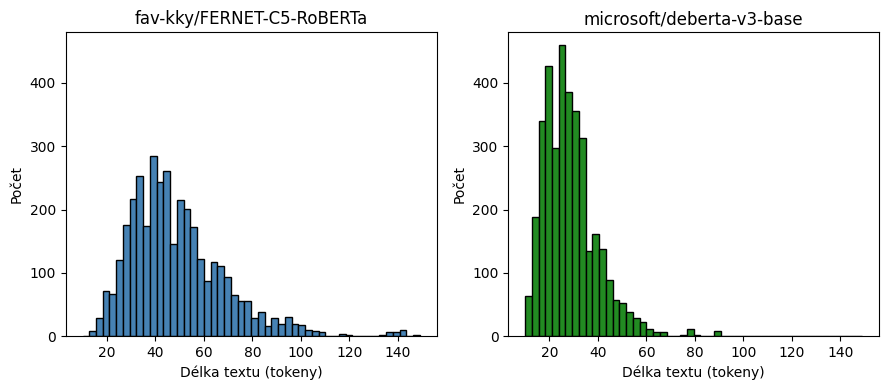

In [ ]:
plot_tokenized_text_comparison("fav-kky/FERNET-C5-RoBERTa", "microsoft/deberta-v3-base", dataset)

### Comparison between tokenizors of different languages
Comparing same models architectures, but with regard to their differnet trainig datasets

#### BERT models

The maximum length of tokenized text in dataset with bert-base-uncased: 95
The maximum length of tokenized text in dataset with bert-base-multilingual-cased: 109


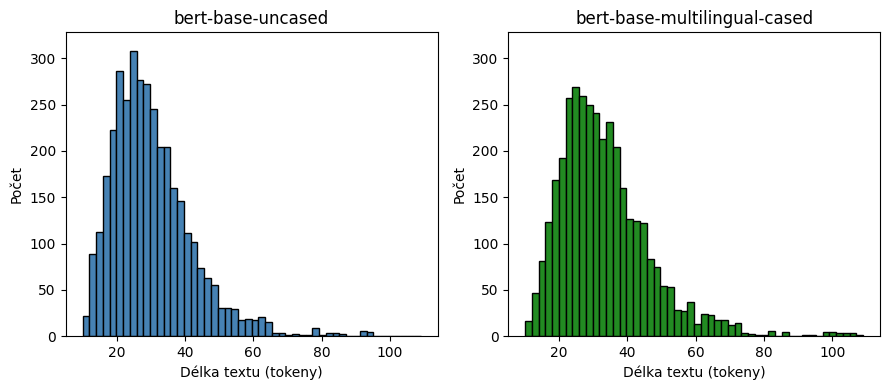

In [ ]:
plot_tokenized_text_comparison("bert-base-uncased", "bert-base-multilingual-cased", dataset)

The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased: 123
The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 133


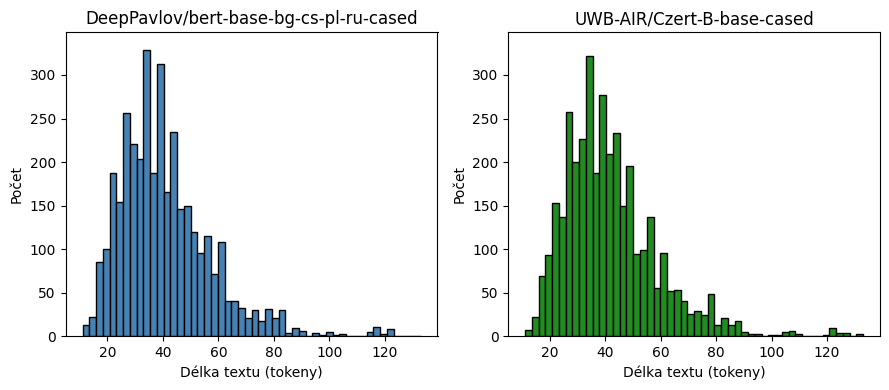

In [ ]:
plot_tokenized_text_comparison("DeepPavlov/bert-base-bg-cs-pl-ru-cased", "UWB-AIR/Czert-B-base-cased", dataset)

The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 133
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5: 133


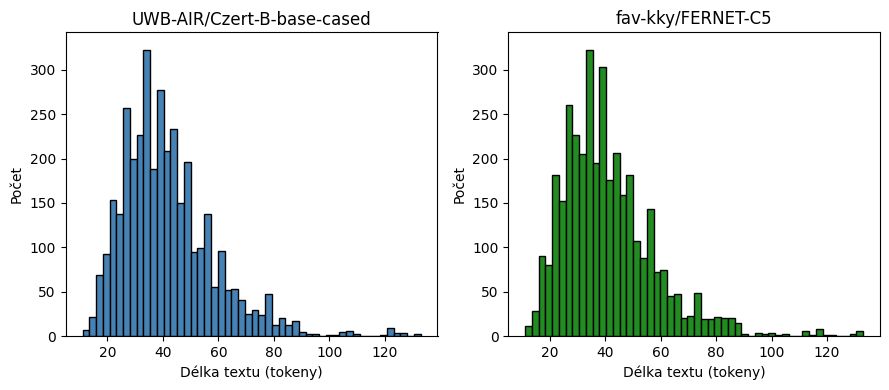

In [ ]:
plot_tokenized_text_comparison("UWB-AIR/Czert-B-base-cased", "fav-kky/FERNET-C5", dataset)

#### RoBERTa models

The maximum length of tokenized text in dataset with roberta-base: 99
The maximum length of tokenized text in dataset with xlm-roberta-base: 101


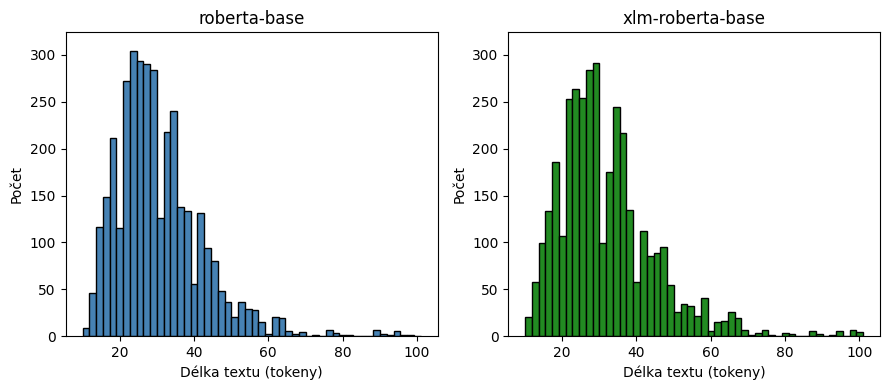

In [ ]:
plot_tokenized_text_comparison("roberta-base", "xlm-roberta-base", dataset)

The maximum length of tokenized text in dataset with ufal/robeczech-base: 143
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 149


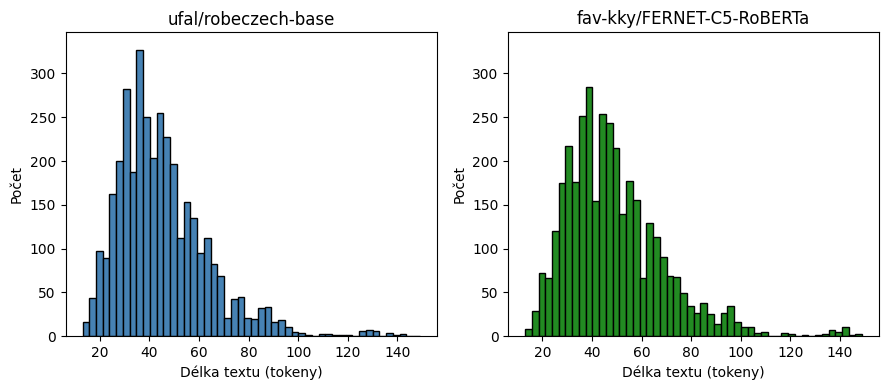

In [ ]:
plot_tokenized_text_comparison("ufal/robeczech-base", "fav-kky/FERNET-C5-RoBERTa", dataset)

#### DeBERTaV3 vs ModernBERT - newest English models

The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 90
The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base: 104


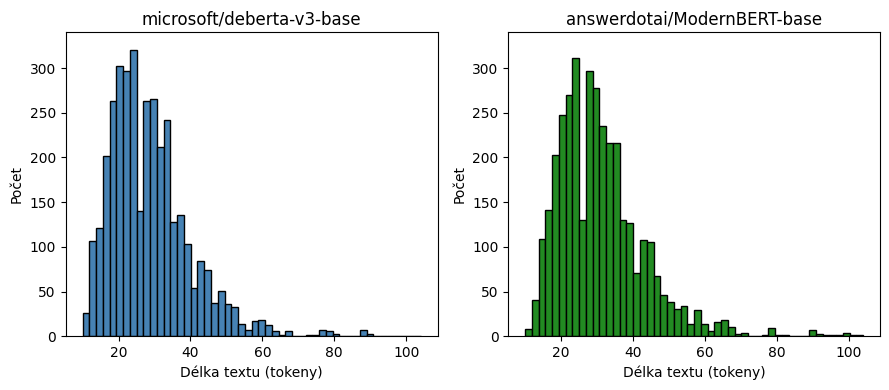

In [ ]:
plot_tokenized_text_comparison("microsoft/deberta-v3-base", "answerdotai/ModernBERT-base", dataset)